In [65]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from svetlanna import optimize as opt
from svetlanna import SimulationParameters
from svetlanna import beam_generator
from svetlanna import elements

Рассмотрим оптическую систему, состоящую из источника, генерирующего пучок Гаусса и находящегося в задней фокальной плоскости собирающей линзы, собирающей линзы и экрана, находящего в передней фокальной плоскости. 

Сначала решим прямую задачу и посмотрим, какое распределение интенсинвости получится, если через такую систему пройдет пучок. Затем решим обратную задачу: зная распределение интенсивности на экране после прохождения описанной выше оптической системы и распределение интенсивности в плоскости перед линзой, попробуем найти функцию пропускания линзы

Решаем прямую задачу:

In [66]:
lx = 5
ly = 5

Nx = 1000
Ny = 100
lam = 1064 * 1e-6

focal = 100
r = 100
distance = focal

w0 = 1

x = np.linspace(-lx/2, lx/2, Nx)
y = np.linspace(-ly/2, ly/2, Ny)
xv, yv = np.meshgrid(x, y)

params = SimulationParameters(
    x_size=lx,
    y_size=ly,
    x_nodes=Nx,
    y_nodes=Ny,
    wavelength=lam
)


In [67]:
lens = elements.ThinLens(simulation_parameters=params, focal_length=focal, radius=r)

phase_func_lens = (torch.real(torch.log(lens.get_transmission_function()) / 1j) + (2 * torch.pi)) % (2 * torch.pi)

field_before_lens = beam_generator.GaussianBeam(simulation_parameters=params).forward(distance=distance, waist_radius=w0)
intensity_source = torch.pow(torch.abs(field_before_lens), 2).detach().numpy()

field_after_lens = lens.forward(input_field=field_before_lens)

In [68]:
def forward_propagation(incident_field: torch.Tensor) -> torch.Tensor:
    field = elements.FreeSpace(simulation_parameters=params, distance=torch.tensor(focal), method='fresnel').forward(input_field=incident_field)
    return field

def reverse_propagation(transmission_field: torch.Tensor) -> torch.Tensor:
    field = elements.FreeSpace(simulation_parameters=params, distance=torch.tensor(focal), method='fresnel').reverse(transmission_field=transmission_field)
    return field

In [69]:
output_field = forward_propagation(field_after_lens)
intensity_target = torch.pow(torch.abs(output_field), 2).detach().numpy()

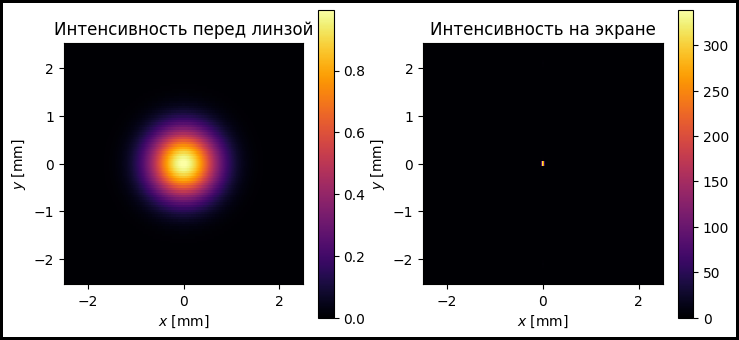

In [70]:
fig, ax = plt.subplots(
    1, 2, figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax[0].pcolormesh(xv, yv, intensity_source, cmap='inferno')
ax[0].set_aspect('equal')
ax[0].set_title(r'Интенсивность перед линзой')
ax[0].set_xlabel('$x$ [mm]')
ax[0].set_ylabel('$y$ [mm]')
fig.colorbar(im1)

im2 = ax[1].pcolormesh(xv, yv, intensity_target, cmap='inferno')
ax[1].set_aspect('equal')
ax[1].set_title(r'Интенсивность на экране')
ax[1].set_xlabel('$x$ [mm]')
ax[1].set_ylabel('$y$ [mm]')
fig.colorbar(im2)

Интенсивность на картинке выше справа должны получить после оптимизации

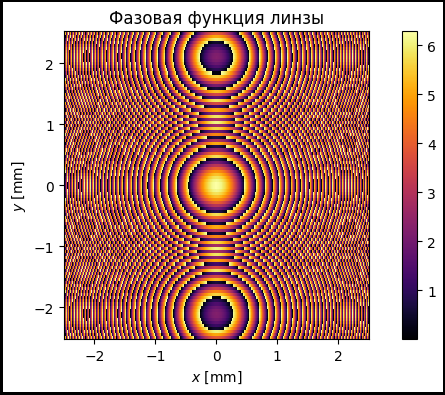

In [71]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, phase_func_lens, cmap='inferno')
ax.set_aspect('equal')
ax.set_title(r'Фазовая функция линзы')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

In [72]:
optimized_phase_func, binary = opt.Optimizer(simulation_parameters=params, target_intensity=torch.tensor(intensity_target), source_intensity=torch.tensor(intensity_source)).gerchberg_saxton_algorithm(forward=forward_propagation, reverse=reverse_propagation, initial_approximation=torch.rand(Ny, Nx))

tensor(6.6930e-07)
tensor(6.2771e-07)


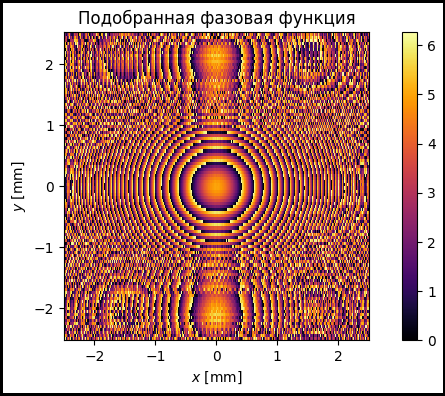

In [75]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, optimized_phase_func, cmap='inferno')
ax.set_aspect('equal')
ax.set_title(r'Подобранная фазовая функция')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)

Снова решаем прямую задачу, но уже с подобранной маской:

In [76]:
field_before_slm = beam_generator.GaussianBeam(simulation_parameters=params).forward(distance=distance, waist_radius=w0)

field_after_slm = elements.SpatialLightModulator(simulation_parameters=params, mask=binary).forward(field_before_slm)

output_field = forward_propagation(field_after_slm)
intensity_target_opt = torch.pow(torch.abs(output_field), 2).detach().numpy()

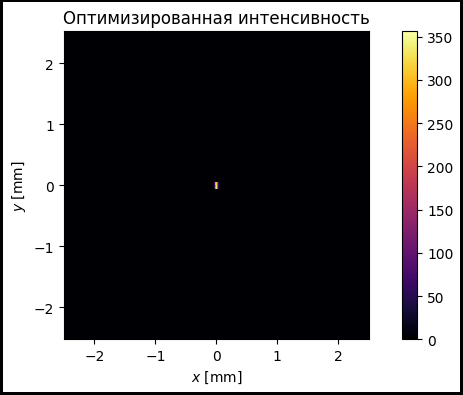

In [77]:
fig, ax = plt.subplots(figsize=(8.5, 4), edgecolor='black', linewidth=3, frameon=True
)
im1 = ax.pcolormesh(xv, yv, intensity_target_opt, cmap='inferno')
ax.set_aspect('equal')
ax.set_title(r'Оптимизированная интенсивность')
ax.set_xlabel('$x$ [mm]')
ax.set_ylabel('$y$ [mm]')
fig.colorbar(im1)